In [3]:
import json 
import re
from matplotlib import pyplot as plt 
import seaborn as sns
import numpy as np 
import pandas as pd
import pathlib 

from calibration_metric import ECEMetric
from calibration_utils import get_accs_sql, read_benchclamp_file, get_probs_and_accs_benchclamp

In [11]:


paths = ["/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/bart-large_spider_past_none_db_val_all_0.0001_5000_test_eval_unconstrained-beam_bs_5/model_outputs.20230208T031316.jsonl",
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/t5-small-lm-adapt_spider_past_none_db_val_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20230203T092044.jsonl",
        # "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/t5-base-lm-adapt_spider_past_none_db_val_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20230206T093954.jsonl",
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/t5-large-lm-adapt_spider_past_none_db_val_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20230208T064137.jsonl",
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/bart-base_spider_past_none_db_val_all_0.0001_5000_test_eval_unconstrained-beam_bs_5/model_outputs.20230208T060905.jsonl",
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/bart-large_spider_past_none_db_val_all_0.0001_5000_test_eval_unconstrained-beam_bs_5/model_outputs.20230208T031316.jsonl",
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/codet5-base_spider_past_none_db_val_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20230208T214405.jsonl"]

spider_gold_path = "/brtx/601-nvme1/estengel/resources/data/benchclamp/processed/Spider/test_all.jsonl"
all_dfs = []
for path in paths: 
    bart_data = read_benchclamp_file(path)
    path = pathlib.Path(path)
    model_name = path.parent.name.split("_")[0]
    model_name = re.sub("-lm-adapt", "", model_name) 
    bart_min_probs, bart_mean_probs, bart_exact_accs = get_probs_and_accs_benchclamp(bart_data) # , spider_gold_path) 

    ece_metric = ECEMetric(n_bins=20, binning_strategy="adaptive")

    (min_values_em, 
    min_bins, 
    min_bin_number) = ece_metric.adaptive_bin(bart_min_probs, bart_exact_accs)

    min_df_to_plot_em = ece_metric.bins_to_df(min_values_em, min_bins, min_bin_number)
    min_df_to_plot_em["model"] = model_name

    source_ppl_data = json.load(open(f"spider_test_by_{model_name}_bin/conf_and_ppl_source.json"))
    target_ppl_data = json.load(open(f"spider_test_by_{model_name}_bin/conf_and_ppl_target.json"))

    print(model_name)
    print(len(source_ppl_data), len(min_df_to_plot_em))
    # sort by confidence, decreasing
    target_ppl_data = sorted(target_ppl_data, key=lambda x: x[0], reverse=True)
    source_ppl_data = sorted(source_ppl_data, key=lambda x: x[0], reverse=True)
    # add source data to df 
    min_df_to_plot_em['target_ppl'] = [x[1] for x in target_ppl_data]
    min_df_to_plot_em['source_ppl'] = [x[1] for x in source_ppl_data]
    all_dfs.append(min_df_to_plot_em)

bart-large
7 7
t5-small
10 10
t5-large
7 7
bart-base
9 9
bart-large
7 7
codet5-base
7 7


In [12]:
# concat all dfs 
all_dfs = pd.concat(all_dfs)

In [13]:
# ece is absolute difference between model and correct

# min_df_to_plot_em['bin_ece'] = min_df_to_plot_em['prob_model'] - min_df_to_plot_em['prob_correct']
# min_df_to_plot_em['bin_ece'] = min_df_to_plot_em['bin_ece'].abs()
all_dfs['bin_ece'] = all_dfs['prob_model'] - all_dfs['prob_correct']
all_dfs['bin_ece'] = all_dfs['bin_ece'].abs()

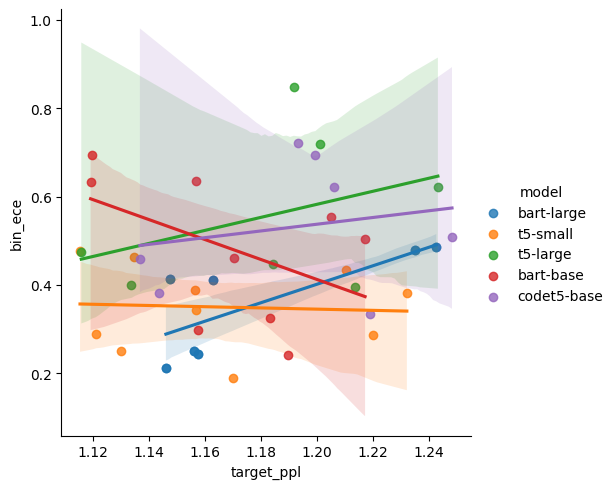

<Figure size 640x480 with 0 Axes>

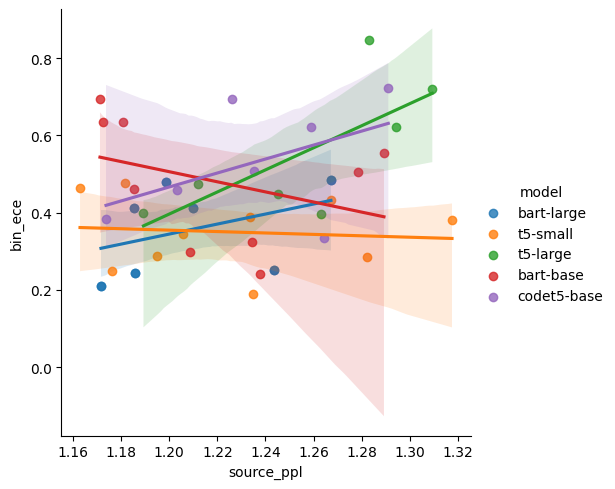

In [18]:


sns.lmplot(data= all_dfs, x='target_ppl', y='bin_ece', scatter=True, hue="model")
plt.figure()
sns.lmplot(data= all_dfs, x='source_ppl', y='bin_ece', scatter=True, hue="model")